In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
# copy from week3
import helper as h

Repeat model from week #3

In [4]:
train, val, test, y_train, y_val, y_test = h.split_telco_data(explore=False)

In [5]:
X_train, X_val, X_test = h.encode_dict_vect(train, val, test)

In [6]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [11]:
y_pred = model.predict_proba(X_val)[:, 1]

#### Accuracy

In [13]:
churn = y_pred >= 0.5
(churn == y_val).mean()

0.7920511000709723

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, y_pred>=0.5)

0.7920511000709723

In [17]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.269
0.05 0.537
0.10 0.612
0.15 0.670
0.20 0.712
0.25 0.739
0.30 0.759
0.35 0.771
0.40 0.780
0.45 0.786
0.50 0.792
0.55 0.793
0.60 0.786
0.65 0.778
0.70 0.760
0.75 0.746
0.80 0.732
0.85 0.731
0.90 0.731
0.95 0.731
1.00 0.731


Best accuracy score with the threshold 0.55

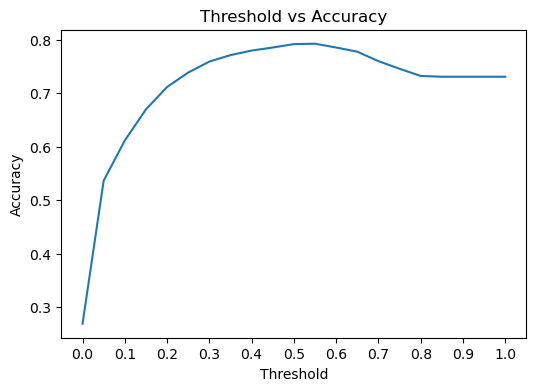

In [18]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies)

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [20]:
# baseline predictions for validation set
baseline = np.repeat(False, len(y_val))
baseline

array([False, False, False, ..., False, False, False])

In [21]:
accuracy_score(y_val, baseline)

0.7310149041873669

#### Confusion Table in Numpy

In [22]:
# correct predictions
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

# false predictions

# type 1 error - false positiv
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
# type 2 error - false negative
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()

In [23]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[932,  98],
       [195, 184]])

In [24]:
# percentage
confusion_table / confusion_table.sum()

array([[0.66146203, 0.06955287],
       [0.13839603, 0.13058907]])

#### Precision and recall

$Precision = \frac{TP}{TP + FP}$           $Recall = \frac{TP}{TP + FN}$

In [27]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(0.6524822695035462, 0.48548812664907653)

### F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

#### ROC and AUC for binary classifications

An __ROC curve__ (receiver operating characteristic curve) is a graph showing the _performance_ of a classification model at _all classification thresholds_. This curve plots two parameters: __TPR__ - _True Positive Rate_ and __FPR__ - _False Positive Rate_

__TPR__ is the same as recall:

$TPR = \frac{TP}{TP + FN}$

__FPR__ is the rate of false positive to false positive with true negative.

$FPR = \frac{FP}{FP + TN}$

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. 

In [28]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [29]:
# every 10th element
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,379,1030,0,0
10,0.1,355,523,24,507
20,0.2,316,343,63,687
30,0.3,283,243,96,787
40,0.4,242,173,137,857
50,0.5,184,98,195,932
60,0.6,131,54,248,976
70,0.7,62,21,317,1009
80,0.8,4,2,375,1028
90,0.9,0,0,379,1030


In [30]:

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [31]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,379,1030,0,0,1.000000,1.000000
10,0.1,355,523,24,507,0.936675,0.507767
20,0.2,316,343,63,687,0.833773,0.333010
30,0.3,283,243,96,787,0.746702,0.235922
40,0.4,242,173,137,857,0.638522,0.167961
50,0.5,184,98,195,932,0.485488,0.095146
60,0.6,131,54,248,976,0.345646,0.052427
70,0.7,62,21,317,1009,0.163588,0.020388
80,0.8,4,2,375,1028,0.010554,0.001942
90,0.9,0,0,379,1030,0.000000,0.000000


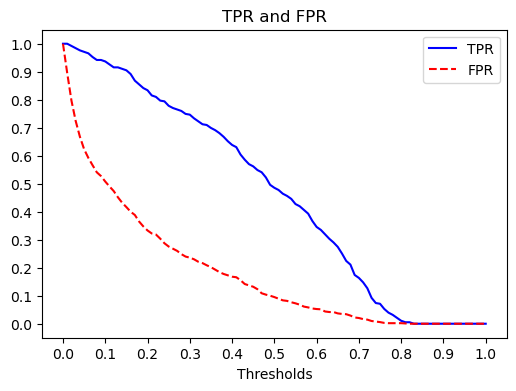

In [33]:
# plot TRP and FPR curves for thresholds
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='red', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

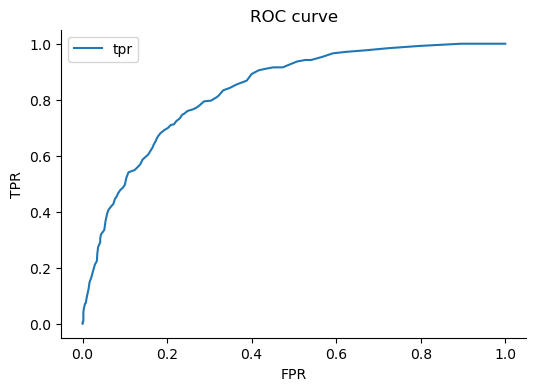

In [40]:
# plot ROC curve TRP vs FPR
ax = df_scores.plot(x = 'fpr', y = 'tpr', figsize = (6, 4), title='ROC curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
plt.show()

In [41]:
df_scores.tpr.min(), df_scores.tpr.max()

(0.0, 1.0)

In [42]:
### function creates a scores dataframe from y_val and y_pred
def tpr_fpr_dataframe(y_val, y_pred):
    ''' 
    creates a scores dataframe from y_val and y_pred
    '''
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        # true positive
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        # true negative
        tn = ((y_pred < t) & (y_val == 0)).sum()
        # false positive
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        # false negative
        fn = ((y_pred < t) & (y_val == 1)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

#### Random model and random baseline

In [43]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,379,1030,0,0,1.000000,1.000000
10,0.1,336,934,43,96,0.886544,0.906796
20,0.2,301,828,78,202,0.794195,0.803883
30,0.3,263,737,116,293,0.693931,0.715534
40,0.4,219,642,160,388,0.577836,0.623301
50,0.5,185,535,194,495,0.488127,0.519417
60,0.6,148,422,231,608,0.390501,0.409709
70,0.7,101,322,278,708,0.266491,0.312621
80,0.8,61,223,318,807,0.160950,0.216505
90,0.9,30,111,349,919,0.079156,0.107767


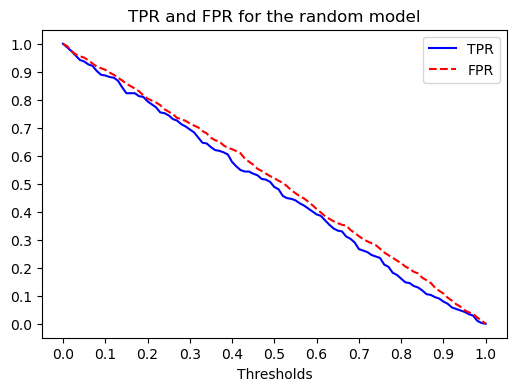

In [44]:
plt.figure(figsize=(6, 4))

plt.plot(df_rand.threshold, df_rand.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='red', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

plt.show()

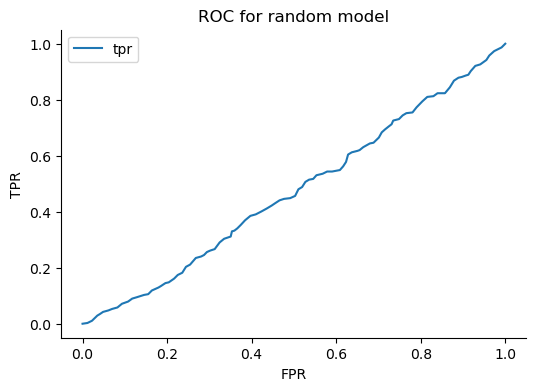

In [45]:
# plot ROC curve TRP vs FPR
ax = df_rand.plot(x = 'fpr', y = 'tpr', figsize = (6, 4), title='ROC for random model')
plt.ylabel('TPR')
plt.xlabel('FPR')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
plt.show()

#### Ideal model and ideal baseline

In [47]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

np.repeat([0, 1], [num_neg, num_pos])

array([0, 0, 0, ..., 1, 1, 1])

In [49]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

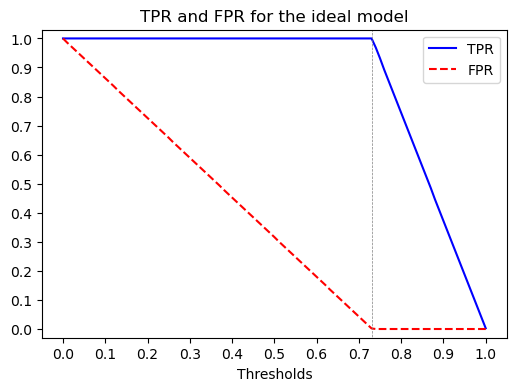

In [50]:
plt.figure(figsize=(6, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='red', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

plt.show()

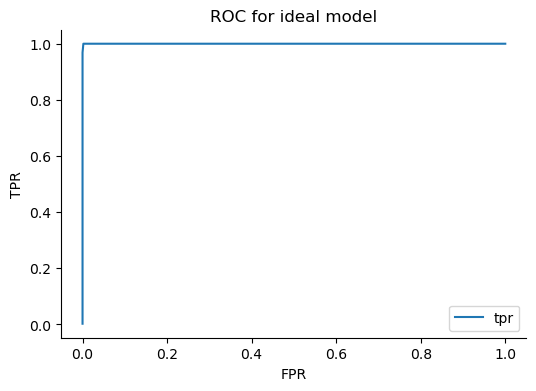

In [51]:
ax = df_ideal.plot(x = 'fpr', y = 'tpr', figsize = (6, 4), title='ROC for ideal model')
plt.ylabel('TPR')
plt.xlabel('FPR')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

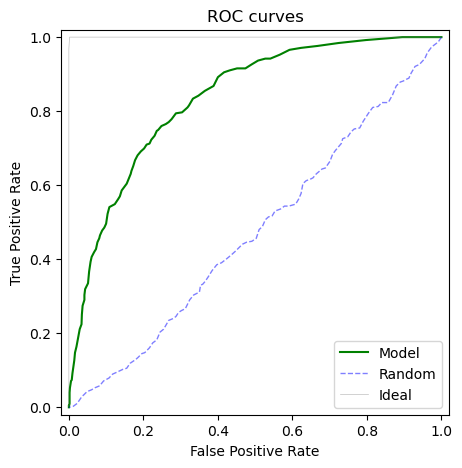

In [53]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='green', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='blue', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='grey', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curves')

plt.show()

The model performs better when it's getting clother to the 90 degrees angle of the ideal model and as far as possible from the diagonal (random) line.

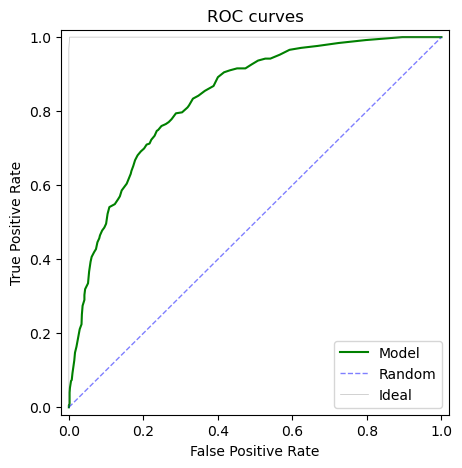

In [54]:
# replace the random model with the diagonal line
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='green', label='Model')
plt.plot([0, 1], [0, 1], color='blue', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='grey', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curves')

plt.show()

at (0, 0) ->  all customers are not churning. The threshold is 1. True positive rate is 0, because there are no churning customers, and False positive rate is 0 because we have only true negatives.

at (1, 1) the threshold is 0 and all customers are churning. TPR is 100%, because all customers that churned are correctly identified as churned ones. And the FPR is 1 because all customers that didn't churn (true negatives) were identified as churned.

#### Plot ROC curve with Scikit Learn

In [56]:
from sklearn.metrics import roc_curve

In [60]:
fpr, tpr, threshholds = roc_curve(y_val, y_pred)

In [63]:
len(threshholds)

394

This line is more accurate, because it uses more threshholds.

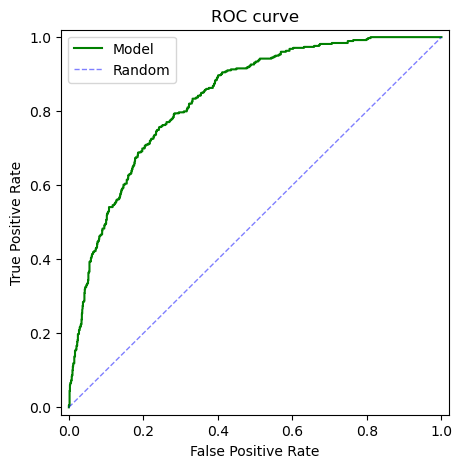

In [62]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='green', label='Model')
plt.plot([0, 1], [0, 1], color='blue', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

### AUC ROC
area under the ROC curve. As closer to 1 is the auc value - as better is the model.

AUC of random model is 0.5, AUC of the ideal model is 1.

In [64]:
from sklearn.metrics import auc # works for any curve!

`auc(x, y)` calculates the area under the any curve. `x, y` -> arrays of values

In [65]:
auc(fpr, tpr)

0.8337039219202295

In [66]:
# our threshholds are pretty accurate
auc(df_scores.fpr, df_scores.tpr)

0.8329635986371905

In [67]:
# ideal model
auc(df_ideal.fpr, df_ideal.tpr)

0.9999692599328842

In [68]:
# random model
auc(df_rand.fpr, df_rand.tpr)

0.47277582806055796

In [69]:
fpr, tpr, threshholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8337039219202295

Shortcut:

In [70]:
from sklearn.metrics import roc_auc_score

In [71]:
roc_auc_score(y_val, y_pred)

0.8337039219202295

__AUC__ is telling us the probability that the score (y_pred) of randomly selected positive example is higher that the score of randomly selected negative example.

Let's confirm it with `numpy`.

In [78]:
import random

In [79]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

pos_ind = random.randint(0, len(pos) - 1)
neg_ind = random.randint(0, len(neg) - 1)

pos[pos_ind] > neg[neg_ind]

True

In [80]:
n = 100_000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n


0.83479

The random value is relatively close to the calculated `auc` value 0.8337039219202295

In [82]:
# the same but generate n-size numpy arrays of random indexes
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [84]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.83449